In [1]:
import lucene
from org.apache.lucene.document import Document, Field
from org.apache.lucene.search import IndexSearcher, Explanation
from org.apache.lucene.search.similarities import TFIDFSimilarity, LMJelinekMercerSimilarity;
from org.apache.lucene.index import IndexReader,DirectoryReader,TermsEnum,Term
from org.apache.lucene.queryparser.classic import QueryParser
from org.apache.lucene.store import SimpleFSDirectory, FSDirectory
from org.apache.lucene.util import Version, BytesRefIterator
from org.apache.lucene.analysis.standard import StandardAnalyzer
from org.apache.lucene.analysis.core import WhitespaceAnalyzer 
from org.apache.lucene.queryparser.flexible.standard import StandardQueryParser
from sklearn.utils import check_random_state
from functools import partial
import numpy as np
from java.io import File
from org.apache.lucene.analysis.en import EnglishAnalyzer
import lime
from lime import lime_ranker
import re, os
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from plotly.offline import init_notebook_mode,iplot, plot
import plotly.graph_objs as go
import plotly.plotly as py
from IPython.display import display
from scipy.stats import entropy
from sklearn.metrics.pairwise import cosine_similarity
import ipyparallel as ipp

In [2]:
class QRel:
    def __init__(self):
        self.query_label = {}
        self.doc_label = {}
    
    def set_rel(self, query_id, doc_id, rel_label):
        if query_id not in self.query_label:
            self.query_label[query_id] = {}
        
        self.query_label[query_id][doc_id] = rel_label
        
        if doc_id not in self.doc_label:
            self.doc_label[doc_id] = {}
        
        self.doc_label[doc_id][query_id] = rel_label
        
    def get_rel(self, query_id, doc_id):
        try:
            return self.query_label[query_id][doc_id]
        except Exception as ex:
            print(ex)
        return -1

In [3]:
# Load the samples
lucene_index_path = '/Users/manishav/workspace/irexplain/data/trec/index_old/'
samples_path = '/Users/manishav/workspace/irexplain/samples/200_sized_samples/samples_0.1_tfidf.txt'


def load_qrels(qrel_path):
    qrel = {}
    with open(qrel_path,'r') as ifile:
        for line in ifile:
            split = line.split()
    


def load_samples(file_path):
    samples_list = {}
    with open(file_path, 'r') as ifile:
        for line in ifile:
            split = line.split('\t')
            doc_id = split[1][:split[1].rindex('_')]
            try:
                index_key = (split[0],doc_id, float(split[5]))
                if index_key not in samples_list:
                    samples_list[index_key] = []
                samples_list[index_key].append({ 'sample_id':split[1], 'sample_text': split[3].strip(),\
                                         'sample_score': float(split[4])})
            except:
                print(split)
    return samples_list

#[\\\\/:*?"<>|]

def tokenize_text(text):
    # remove symbols
    ntext = re.sub(r'\W+', ' ', text)
    analyzer = EnglishAnalyzer()
    parser = StandardQueryParser(analyzer)
    parsed_text = parser.parse(ntext,'').toString('')
    parsed_text = re.sub('[)()]', '', parsed_text)
    return parsed_text


def consistancy(explanation_objects):
    '''
        Compares the relative differences in explanations for the same document accross different sampling 
    '''
    #kendall_values = {}
    scores = []
    for i in range(len(explanation_objects)):
        #kendall_values[i] = {}
        for j in range(i+1,len(explanation_objects)):
            kscore = kendalltau(explanation_objects[i],explanation_objects[j])
            if kscore[1] < 0.05:
                #kendall_values[i][j] = kscore[0] 
                scores.append(kscore[0])
    return np.mean(scores)



def divergence_from_truth(rel_vector, non_rel_vector,  explain_vector):
    
    
    # find the common words in all three vectors.    
    all_vectors = pd.DataFrame({'rel_vector': rel_vector, \
                  'non_rel_vector':non_rel_vector,\
                  'explain_vector': explain_vector}).fillna(0.0)
    
    #print(all_vectors[all_vectors['explain_vector'] > 0].head())

    norm_df = all_vectors.apply(lambda x: x/x.max(), axis=0)
    neg_ent = entropy(norm_df['non_rel_vector'].values,norm_df['explain_vector'].values )
    pos_ent = entropy(norm_df['rel_vector'].values,norm_df['explain_vector'].values )
    print(neg_ent, pos_ent, norm_df.shape)
    
    '''
    # Compute KL Divergence between relevant and non-relevant    
    neg_ent =  cosine_similarity([all_vectors['non_rel_vector'].values],\
          [all_vectors['explain_vector'].values])
    pos_ent =  cosine_similarity([all_vectors['rel_vector'].values], \
                                 [all_vectors['explain_vector'].values])
    #print(neg_ent, pos_ent, len(explain_vector), all_vectors.shape)
    '''
    
    return  neg_ent, pos_ent, neg_ent[0]/pos_ent[0]
    
    
def compute_query_document_vectors(qrel_path, lime_object):
    # Read the qrel file
    qrel_object = QRel()
    
    query_vectors = {}
    doc_counts = {}
    for line in open(qrel_path, 'r'):
        split = line.split(' ')
        query_id = split[0]
        doc_id = split[2]
        rel_label = int(split[3])
        if query_id not in query_vectors:
            query_vectors[query_id] = {}
            doc_counts[query_id] = {}
        
        if rel_label not in query_vectors[query_id]:
            query_vectors[query_id][rel_label] = {}
            doc_counts[query_id][rel_label] = 0.0
            
        qrel_object.set_rel(query_id, doc_id, rel_label)
        
        if doc_counts[query_id][rel_label] < 50:
            doc_vector = lime_object.get_document_vector(doc_id,'id','words')
       
            for entry , value in doc_vector.items():
                if entry not in query_vectors[query_id][rel_label]:
                    query_vectors[query_id][rel_label][entry] = value
                else:
                    query_vectors[query_id][rel_label][entry] += value
                
            doc_counts[query_id][rel_label] += 1.0
        
    # normalize the vectors.
    for query_id in query_vectors.keys():
        for rel_label in query_vectors[query_id].keys():
            for word in query_vectors[query_id][rel_label].keys():
                query_vectors[query_id][rel_label][word]/=doc_counts[query_id][rel_label]
        
 
    return qrel_object, query_vectors


def explanation_to_vector(word_list, explain_tuples, doc_vector):
    #print(explain_tuples)
    return dict([ (word_list[entry[0]] , doc_vector[word_list[entry[0]]]) for entry in explain_tuples])
    
    

In [4]:
#env = lucene.getVMEnv()
env = lucene.initVM(classpath=lucene.CLASSPATH, vmargs=['-Djava.awt.headless=true'])
index_path = File(lucene_index_path).toPath()
index_dir = FSDirectory.open(index_path)
reader = DirectoryReader.open(index_dir)
searcher = IndexSearcher(reader)
        

In [5]:
ranker_explanation = lime_ranker.LimeRankerExplainer(kernel_width = np.sqrt(100000) * .80,\
                                                     relevance_labels=[0,1,2,3,4],\
                                                     lucene_index_reader=reader, \
                                                     lucene_index_searcher= searcher)

In [6]:
samples = load_samples(samples_path)

['449 ', 'LA060590-0014_179', '', 'suppresses theological tremendous side intr']


In [7]:
kernel_range = np.outer(np.logspace(2,7,num=9-2+1,base=10,dtype='int')  , np.linspace(0.1, 1.0, 10)).ravel()

In [8]:
qrel_path = '/Users/manishav/workspace/irexplain/data/trec/qrels/qrels.trec8.adhoc'
qrel_object, query_vectors = compute_query_document_vectors(qrel_path, ranker_explanation)

In [18]:
def compute_metrics(top_k):
    consistancy_scores=[]
    divergence_scores=[]
    query_count = {}
    for index_key, sample_list in samples.items():
        # index_key --> query_id, doc_id, doc_score
        query_id = index_key[0].strip()
        if query_id not in query_count:
            print('Evaluating for query', index_key[0], top_k)
            query_count[query_id] = 0
        query_count[query_id] +=1
        
        sample_scores = [x['sample_score'] for x in sample_list]
        sample_texts = [tokenize_text(x['sample_text']) for x in sample_list]
        document_dict = ranker_explanation.get_document_vector(index_key[1],\
                                                    'id','words')
        doc_label = qrel_object.get_rel(query_id, index_key[1])
        word_list = list(document_dict.keys())
        
        explain_objects = ranker_explanation.explain_document_label(document_dict, index_key[2],\
                                                               sample_texts, sample_scores, top_k,\
                                                                weights_range=kernel_range)
        ranked_lists = []
        for eobject, kernel in zip(explain_objects, kernel_range):
            ranked_lists.append([entry[0] for entry in sorted(eobject.local_exp[1],\
                                                              key = lambda x: x[1],\
                                                              reverse=True)])
            ne, pe, dfr = divergence_from_truth(query_vectors[query_id][1],query_vectors[query_id][0],\
                                                                            explanation_to_vector(word_list,\
                                                                            eobject.local_exp[1],\
                                                                            document_dict))
            divergence_scores.append({'doc_id':index_key[1],'top_feat':top_k, 'kernel':kernel, \
                                                'doc_rel':doc_label ,'doc_score':index_key[2], \
                                                'dfr': dfr, 'ne': ne, 'pe':pe, 'query_id': query_id} )
                
        consistancy_scores.append({'doc_id':index_key[1], 'ktau': consistancy(ranked_lists),\
                                                 'doc_score':index_key[2],'top_feat':top_k,\
                                                 'doc_rel':doc_label})
    return consistancy_scores, divergence_scores


In [64]:
L = sorted([(k, k1['doc_id'], k1['doc_score'], k1['ktau'],\
             k1['doc_rel'], k1['top_feat']) for k,v in consistancy_scores.items() for k1 in v], 
            key=lambda x: (x[0], x[1]))
query_consistancy_frame = pd.DataFrame(L, columns=['query_id','doc_id','doc_score', 'ktau', 'doc_rel', 'top_feat'])
query_consistancy_frame.to_csv('kendal_score.csv', sep=',')

In [55]:
init_notebook_mode(connected=True)
data = []
for q in query_consistancy_frame['query_id'].unique():
    trace = go.Scatter(
        x = query_consistancy_frame[query_consistancy_frame['query_id'] == q]['doc_score'],
        y = query_consistancy_frame[query_consistancy_frame['query_id'] == q]['ktau'],
        mode = 'markers', name = q)
    data.append(trace)

layout = dict(title = 'Consistancy scores across queries',
              yaxis = dict(title ='Consistency score' ),
              xaxis = dict(title = "Document Ranker score")
             )
iplot(go.Figure(data=data, layout=layout))

In [ ]:
L = sorted([(k, k1['doc_id'], k1['doc_score'], k1['dfr'], k1['ne'], k1['pe'], k1['kernel'],\
             k1['doc_rel'], k1['top_feat']) for k,v in divergence_scores.items() for k1 in v], 
            key=lambda x: (x[0], x[1]))
df = pd.DataFrame(L, columns=['query_id','doc_id','doc_score', 'dfr','ne','pe', 'kernel',\
                                                   'doc_rel', 'top_feat'])
df.to_csv('divergence_score.csv', sep=',')

In [77]:
%matplotlib inline

#set ggplot style
plt.style.use('ggplot')
kendal_frames= []
divergence_frames = []

hdir ='/Users/manishav/workspace/irexplain/src/main/python/explain'
paths = {'tf-idf (p=0.1)': hdir+'/tf_idf_0.1/gauss/',
         'tf-idf (p=0.3)': hdir+'/tf_idf_0.3/gauss/',
         #'gtf_idf0.5': hdir+'/tf_idf_0.5/gauss/',
         #'utf-idf (p=0.1)':hdir+'/tf_idf_0.1/uniform_kernel/',
         #'utf-idf (p=0.3)':hdir+'/tf_idf_0.3/uniform_kernel/',
         'uniform (p=0.1)':hdir+'/tf_idf_0.1/uniform_prob/',
         'uniform (p=0.3)':hdir+'/tf_idf_0.3/uniform_prob/',
         #'uniform0.5':hdir+'/tf_idf_0.5/uniform_prob/'}
         #'uniform':hdir+'/mask_0.1/uniform_prob/10/',\
         #'gmask0.1_10': hdir+'/mask_0.1/gauss/10/',
         'mask (v=0.1, k=5)': hdir+'/mask_0.1/gauss/5/',
         #'umask (v=0.1, k=5)': hdir+'/mask_0.1/uniform/5/',
         #'gmask0.1_20': hdir+'/mask_0.1/gauss/20/'
         #'gmask0.1_20': hdir+'/mask_0.1/gauss/20/',
         'mask (v=0.3, k=5)': hdir+'/mask_0.3/gauss/5/'}
         #'umask (v=0.3, k=5)': hdir+'/mask_0.3/uniform/5/'}
         #'gmask0.3_20':hdir+'/mask_0.3/gauss/20/'}
         
for subsc, dpath in paths.items():
    for ifile in os.listdir(dpath):
        # read the file and get the average.
        if 'kendal' in ifile:
            frame= pd.read_csv(dpath+'/'+ifile, sep=',')
            frame['sampler'] = subsc#dpath[len(hdir):]
            kendal_frames.append(frame)
        else:
            frame = pd.read_csv(dpath+'/'+ifile, sep=',')
            frame['sampler'] = subsc #dpath[len(hdir):]
            divergence_frames.append(frame)


In [78]:
kendal_frame = pd.concat(kendal_frames, axis = 0, ignore_index = True)
kendal_frame.head()

,doc_id,doc_rel,doc_score,ktau,query_id,top_feat,sampler
0,LA022790-0091,0,9.807556,0.937862,401,20,tf-idf (p=0.1)
1,FBIS3-20090,1,9.290847,0.865695,401,20,tf-idf (p=0.1)
2,FT941-4506,0,9.233107,0.890004,401,20,tf-idf (p=0.1)
3,FBIS4-18372,0,9.083562,0.841630,401,20,tf-idf (p=0.1)
4,FT924-4470,1,8.691005,0.963296,401,20,tf-idf (p=0.1)


In [79]:
kquery_mean = kendal_frame.groupby(['top_feat','sampler','query_id'])['ktau'].agg({'query_mean':np.mean}).reset_index()

In [80]:
print(len(kquery_mean['query_id'].unique()))

49


In [81]:
final_mean = kquery_mean.groupby(['top_feat','sampler'])['query_mean'].agg(np.mean).reset_index()

In [82]:
final_mean

,top_feat,sampler,query_mean
0,10,"mask (v=0.1, k=5)",0.890735
1,10,"mask (v=0.3, k=5)",0.857516
2,10,tf-idf (p=0.1),0.908918
3,10,tf-idf (p=0.3),0.889832
4,10,uniform (p=0.1),0.912240
5,10,uniform (p=0.3),0.907430
6,15,"mask (v=0.1, k=5)",0.850326
7,15,"mask (v=0.3, k=5)",0.848343
8,15,tf-idf (p=0.1),0.871971
9,15,tf-idf (p=0.3),0.863094


Text(21.0, 0.5, 'Consistency')

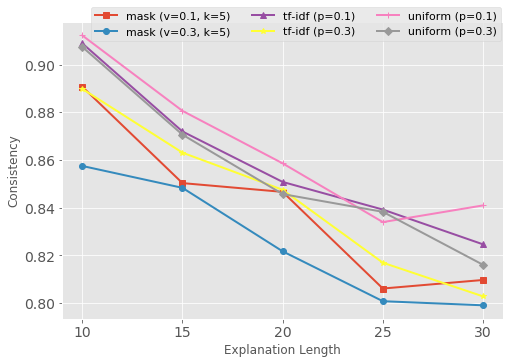

In [105]:
fig, ax = plt.subplots(figsize=(7,5))
styles=['s-', 'o-', '^-', '*-', '+-','D-']
kendal_frame.groupby(['top_feat',\
                      'sampler'])['ktau']\
            .agg(np.mean).unstack().plot(ax=ax, colormap='Set1', lw=2,style = styles , fontsize= 14)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.53, 1.07), ncol=3, fontsize= 11)

ax.set_xticks([10,15,20,25,30])
ax.set_xlabel('Explanation Length')
ax.set_ylabel('Consistency')

Text(21.0, 0.5, 'Consistency')

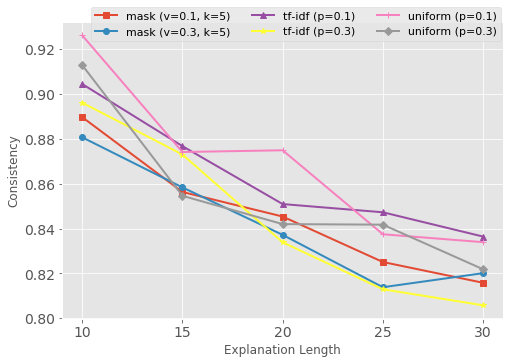

In [110]:
fig, ax = plt.subplots(figsize=(7,5))
styles=['s-', 'o-', '^-', '*-', '+-','D-']
kendal_frame[kendal_frame['doc_rel'] == 1].groupby(['top_feat',\
                                                    'sampler'])['ktau']\
                                          .agg(np.mean).unstack().plot(ax=ax,\
                                                                       colormap='Set1',\
                                                                       lw=2,style = styles , fontsize= 14)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.53, 1.07), ncol=3, fontsize= 11)
ax.set_xticks([10,15,20,25,30])
ax.set_xlabel('Explanation Length')
ax.set_ylabel('Consistency')

Text(0, 0.5, 'Consistency')

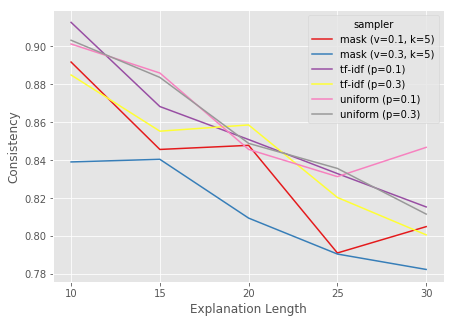

In [120]:
fig, ax = plt.subplots(figsize=(7,5))
kendal_frame[kendal_frame['doc_rel'] == 0].groupby(['top_feat',\
                                                    'sampler'])['ktau']\
                                          .agg(np.mean).unstack().plot(ax=ax,colormap='Set1',\
                                                                       lw=2,style = styles , fontsize= 14)
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.53, 1.07), ncol=3, fontsize= 11)
ax.set_xticks([10,15,20,25,30])
ax.set_xlabel('Explanation Length')
ax.set_ylabel('Consistency')

In [15]:
divergence_frame = pd.concat(divergence_frames, axis = 0, ignore_index = True)
divergence_frame['cdfr'] = divergence_frame['cdfr'].apply(lambda x:x[x.rindex('[')+1:x.index(']')]).apply(float)
divergence_frame['cne'] = divergence_frame['cne'].apply(lambda x:x[x.rindex('[')+1:x.index(']')]).apply(float)
divergence_frame['dne'] = 1.0 - divergence_frame['cne']
divergence_frame['cpe'] = divergence_frame['cpe'].apply(lambda x:x[x.rindex('[')+1:x.index(']')]).apply(float)
divergence_frame['dpe'] = 1.0 - divergence_frame['cpe']
divergence_frame['dcdfr'] =  divergence_frame['dpe']/divergence_frame['dne']
divergence_frame.head()

,cdfr,cne,cpe,dfr,doc_id,doc_rel,doc_score,kernel,ne,pe,query_id,top_feat,sampler,dne,dpe,dcdfr
0,0.982022,0.043484,0.025973,0.928594,LA022790-0091,0,9.807556,0.001,1.98726,2.140074,401,10,tf-idf (p=0.1),0.956516,0.974027,1.018308
1,0.982022,0.043484,0.025973,0.928594,LA022790-0091,0,9.807556,0.002,1.98726,2.140074,401,10,tf-idf (p=0.1),0.956516,0.974027,1.018308
2,0.982022,0.043484,0.025973,0.928594,LA022790-0091,0,9.807556,0.003,1.98726,2.140074,401,10,tf-idf (p=0.1),0.956516,0.974027,1.018308
3,0.982022,0.043484,0.025973,0.928594,LA022790-0091,0,9.807556,0.004,1.98726,2.140074,401,10,tf-idf (p=0.1),0.956516,0.974027,1.018308
4,0.982022,0.043484,0.025973,0.928594,LA022790-0091,0,9.807556,0.005,1.98726,2.140074,401,10,tf-idf (p=0.1),0.956516,0.974027,1.018308


In [22]:
divergence_frame['sampler'].unique()

array(['tf-idf (p=0.1)', 'tf-idf (p=0.3)', 'utf-idf (p=0.1)',
       'utf-idf (p=0.3)', 'uniform (p=0.1)', 'uniform (p=0.3)',
       'mask (v=0.1, k=5)', 'umask (v=0.1, k=5)', 'mask (v=0.3, k=5)',
       'umask (v=0.3, k=5)'], dtype=object)

Text(0, 0.5, 'Divergence from relevance')

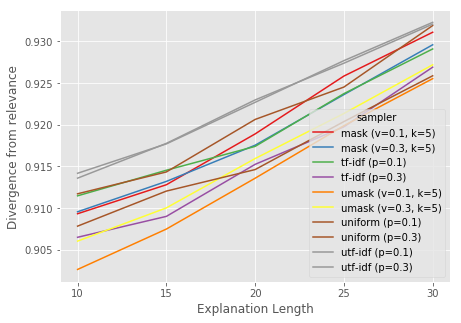

In [26]:
fig, ax = plt.subplots(figsize=(7,5))
divergence_frame.groupby(['top_feat', 'sampler'])['dfr']\
                                             .agg(np.mean).unstack().plot(ax=ax,\
                                                                       colormap='Set1')
ax.set_xticks([10,15,20,25,30])
ax.set_xlabel('Explanation Length')

ax.set_ylabel('Divergence from relevance')


In [37]:
qdiv = divergence_frame.groupby(['top_feat', 'sampler','query_id'])['cpe'].agg({'qmean':np.mean}).reset_index()

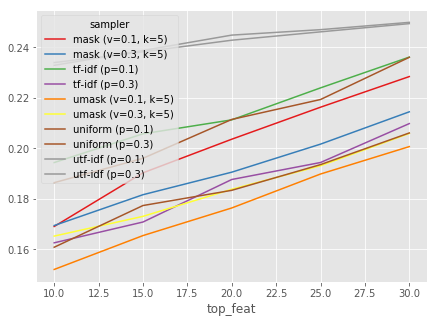

In [50]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(7,5))
qdiv.groupby(['top_feat', 'sampler'])['qmean'].agg(np.mean).unstack().plot(colormap='Set1', ax=ax)

In [44]:
divergence_frame[divergence_frame['kernel'] == 20].groupby(['top_feat', 'sampler'])['cpe'].agg(np.mean).reset_index()

,top_feat,sampler,cpe
0,10,"mask (v=0.1, k=5)",0.201053
1,10,"mask (v=0.3, k=5)",0.223642
2,10,tf-idf (p=0.1),0.240115
3,10,tf-idf (p=0.3),0.197236
4,10,"umask (v=0.1, k=5)",0.155215
5,10,"umask (v=0.3, k=5)",0.162528
6,10,uniform (p=0.1),0.230465
7,10,uniform (p=0.3),0.199831
8,10,utf-idf (p=0.1),0.231369
9,10,utf-idf (p=0.3),0.240794


Text(20.875, 0.5, 'ASR')

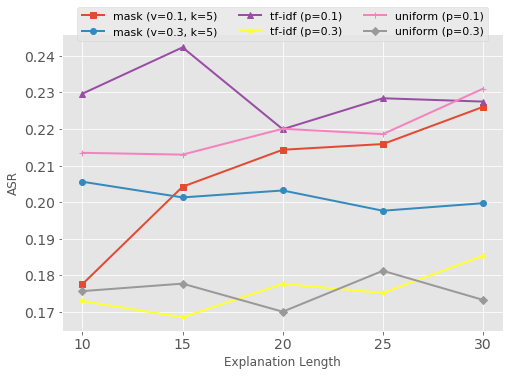

In [124]:
fig, ax = plt.subplots(figsize=(7,5))
divergence_frame[(divergence_frame['kernel']==50000) & (divergence_frame['doc_rel']==0)].groupby(['top_feat', 'sampler'])['cpe']\
                                             .agg(np.mean).unstack().plot(ax=ax, colormap='Set1',\
                                                                          lw=2,style = styles , fontsize= 14)
ax.set_xticks([10,15,20,25,30])
ax.set_xlabel('Explanation Length')
plt.tight_layout()
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11), ncol=3, fontsize= 11)
ax.set_ylabel('ASR')

Text(0, 0.5, 'DCDFR')

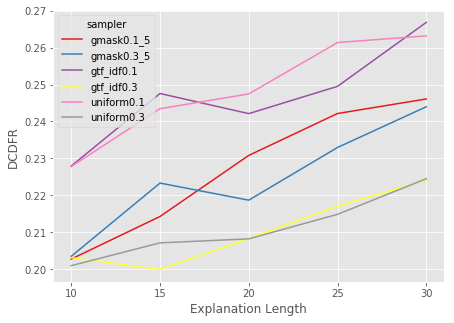

In [124]:
fig, ax = plt.subplots(figsize=(7,5))
small_frame[small_frame['kernel'].isin([5])].groupby(['top_feat', 'sampler'])['cpe']\
                                             .agg(np.mean).unstack().plot(ax=ax,\
                                                                       colormap='Set1')
ax.set_xticks([10,15,20,25,30])
ax.set_xlabel('Explanation Length')
ax.set_ylabel('DCDFR')

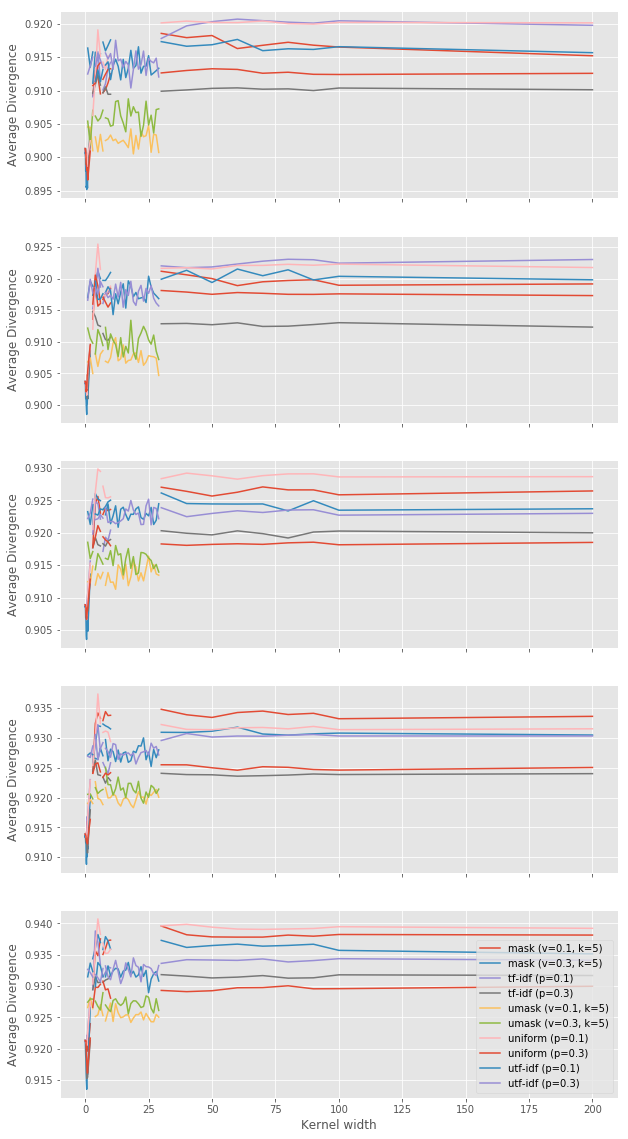

In [18]:
import matplotlib.ticker as ticker
small_frame = divergence_frame[(divergence_frame['kernel'] <=200)  ]

aggregates = small_frame.groupby(['top_feat','kernel','sampler'])['dfr'].agg(np.mean).unstack()
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10,20)) 

for num_words, ax in zip(aggregates.index.levels[0], axs):
    query_result = aggregates.query('top_feat == '+str(num_words)).reset_index().drop(columns=['top_feat'], axis=1)
    query_result.plot( x='kernel', ax=ax,  legend=False, x_compat=True)
    #ax.xaxis.set_ticks(np.arange(start, end, 4))
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    ax.set_xlabel('Kernel width')
    ax.set_ylabel('Average Divergence')
plt.legend()

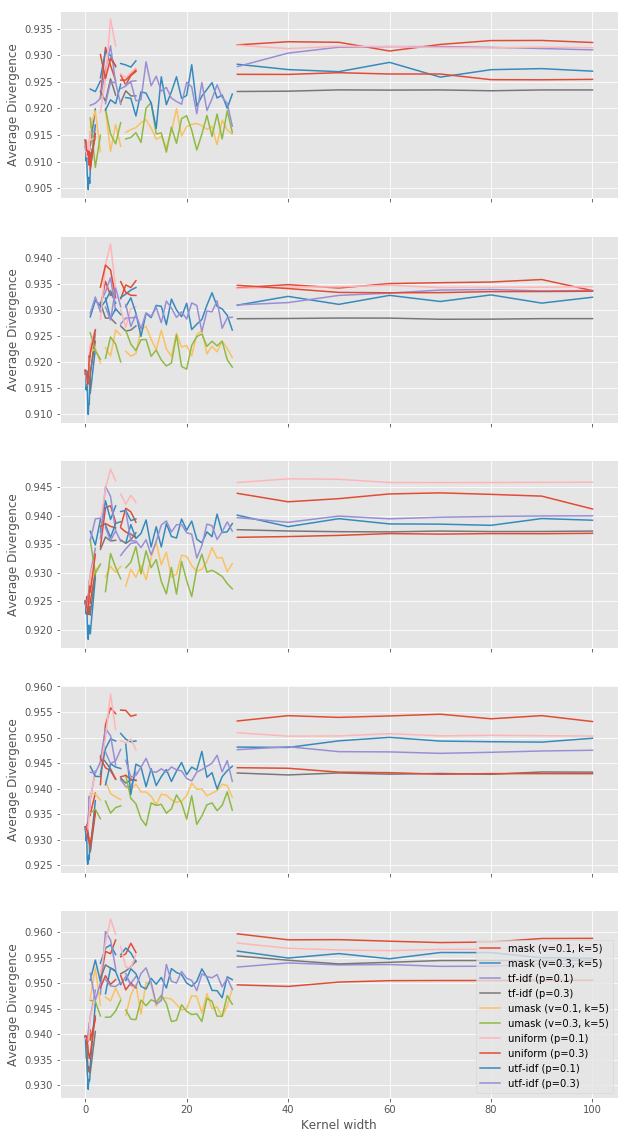

In [17]:
import matplotlib.ticker as ticker
small_frame = divergence_frame[(divergence_frame['kernel'] <= 100) &  (divergence_frame['doc_rel'] ==1)]

aggregates = small_frame.groupby(['top_feat','kernel','sampler'])['dfr'].agg(np.mean).unstack()
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10,20)) 

for num_words, ax in zip(aggregates.index.levels[0], axs):
    query_result = aggregates.query('top_feat == '+str(num_words)).reset_index().drop(columns=['top_feat'], axis=1)
    query_result.plot( x='kernel', ax=ax,  legend=False, x_compat=True)
    #ax.xaxis.set_ticks(np.arange(start, end, 4))
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    ax.set_xlabel('Kernel width')
    ax.set_ylabel('Average Divergence')
plt.legend()

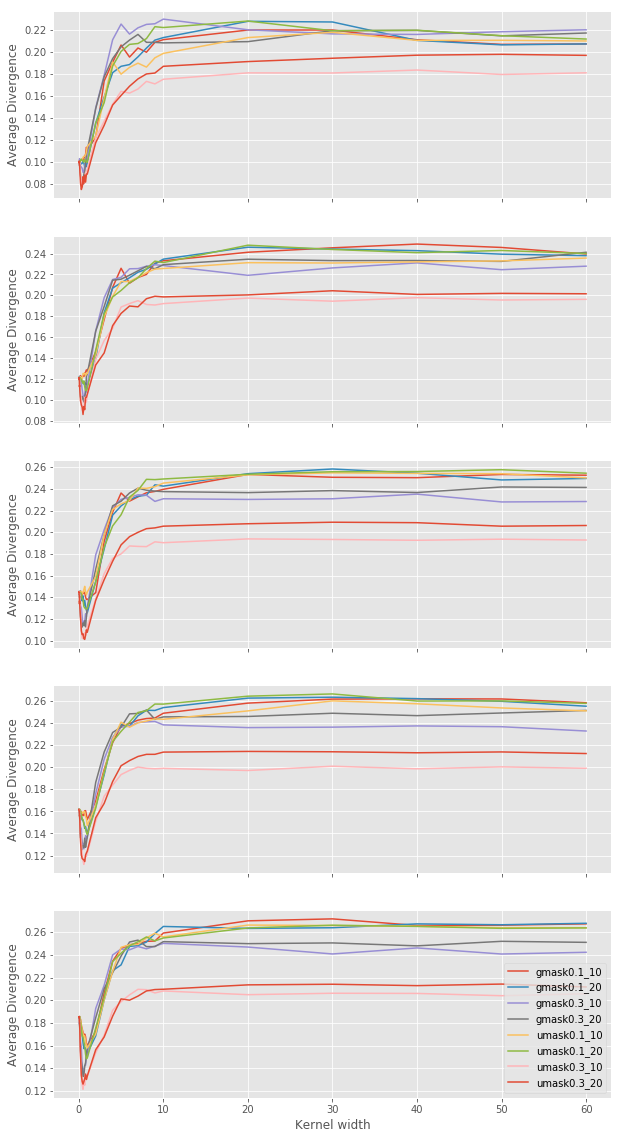

In [382]:
import matplotlib.ticker as ticker
small_frame = divergence_frame[(divergence_frame['kernel'] <= 60)]

aggregates = small_frame.groupby(['top_feat','kernel','sampler'])['cpe'].agg(np.mean).unstack()
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10,20)) 

for num_words, ax in zip(aggregates.index.levels[0], axs):
    query_result = aggregates.query('top_feat == '+str(num_words)).reset_index().drop(columns=['top_feat'], axis=1)
    query_result.plot( x='kernel', ax=ax,  legend=False, x_compat=True)
    #ax.xaxis.set_ticks(np.arange(start, end, 4))
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    ax.set_xlabel('Kernel width')
    ax.set_ylabel('Average Divergence')
plt.legend()

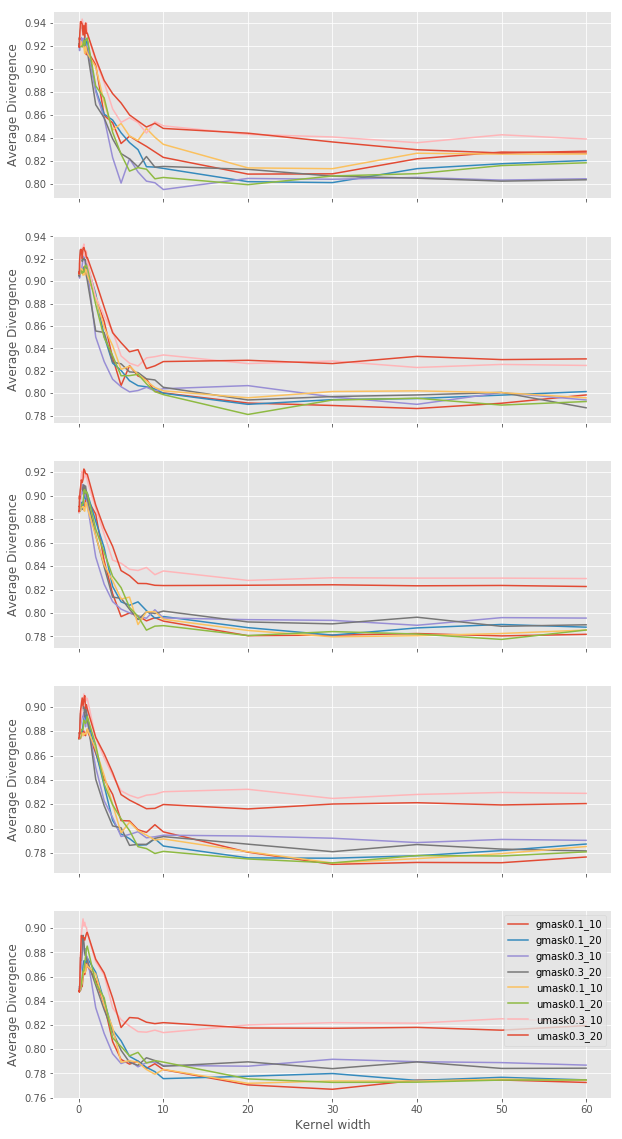

In [383]:
import matplotlib.ticker as ticker
small_frame = divergence_frame[(divergence_frame['kernel'] <= 60) &  (divergence_frame['doc_rel'] ==0)]

aggregates = small_frame.groupby(['top_feat','kernel','sampler'])['dpe'].agg(np.mean).unstack()
fig, axs = plt.subplots(5, 1, sharex=True, figsize=(10,20)) 

for num_words, ax in zip(aggregates.index.levels[0], axs):
    query_result = aggregates.query('top_feat == '+str(num_words)).reset_index().drop(columns=['top_feat'], axis=1)
    query_result.plot( x='kernel', ax=ax,  legend=False, x_compat=True)
    #ax.xaxis.set_ticks(np.arange(start, end, 4))
    #ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.1f'))

    ax.set_xlabel('Kernel width')
    ax.set_ylabel('Average Divergence')
plt.legend()

In [208]:
# load the sample results 

hdir ='/Users/manishav/workspace/irexplain/src/main/python/explain'
paths = {'tf-idf (p=0.1)': hdir+'/tf_idf_0.1/gauss/explanations/',
         'tf-idf (p=0.3)': hdir+'/tf_idf_0.3/gauss/explanations/',
         'uniform (p=0.1)':hdir+'/tf_idf_0.1/uniform_prob/explanation/',
         'uniform (p=0.3)':hdir+'/tf_idf_0.3/uniform_prob/explanation/',
         'mask (v=0.1, k=5)': hdir+'/mask_0.1/gauss/explanation/',
         'mask (v=0.3, k=5)': hdir+'/mask_0.3/gauss/explanation/',
        }
'''
         #'gtf_idf0.5': hdir+'/tf_idf_0.5/gauss/',
         #'utf-idf (p=0.1)':hdir+'/tf_idf_0.1/uniform_kernel/',
         #'utf-idf (p=0.3)':hdir+'/tf_idf_0.3/uniform_kernel/',
         
         #'uniform0.5':hdir+'/tf_idf_0.5/uniform_prob/'}
         #'uniform':hdir+'/mask_0.1/uniform_prob/10/',\
         #'gmask0.1_10': hdir+'/mask_0.1/gauss/10/',
         
         #'umask (v=0.1, k=5)': hdir+'/mask_0.1/uniform/5/',
         #'gmask0.1_20': hdir+'/mask_0.1/gauss/20/'
         #'gmask0.1_20': hdir+'/mask_0.1/gauss/20/',
         'mask (v=0.3, k=5)': hdir+'/mask_0.3/gauss/5/'}
         #'umask (v=0.3, k=5)': hdir+'/mask_0.3/uniform/5/'}
         #'gmask0.3_20':hdir+'/mask_0.3/gauss/20/'}
'''
exp_frames = []
for subsc, dpath in paths.items():
    for ifile in os.listdir(dpath):
        print(ifile)
        # read the file and get the average.
        frame = pd.read_csv(dpath+'/'+ifile)
        frame['sampler'] = subsc #dpath[len(hdir):]
        exp_frames.append(frame)


samples_0.1_tfidf_explanation_scores10.csv
samples_0.1_tfidf_explanation_scores15.csv
samples_0.1_tfidf_explanation_scores25.csv
samples_0.1_tfidf_explanation_scores30.csv
samples_0.1_tfidf_explanation_scores20.csv
samples_0.3_tfidf_explanation_scores25.csv
samples_0.3_tfidf_explanation_scores30.csv
samples_0.3_tfidf_explanation_scores20.csv
samples_0.3_tfidf_explanation_scores10.csv
samples_0.3_tfidf_explanation_scores15.csv
0.1_tfidf_explanation_scores10.csv
0.1_tfidf_explanation_scores15.csv
0.1_tfidf_explanation_scores30.csv
0.1_tfidf_explanation_scores25.csv
0.1_tfidf_explanation_scores20.csv
0.3_tfidf_explanation_scores30.csv
0.3_tfidf_explanation_scores25.csv
0.3_tfidf_explanation_scores20.csv
0.3_tfidf_explanation_scores10.csv
0.3_tfidf_explanation_scores15.csv
mask.ws.5.0.1_explanation_scores25.csv
mask.ws.5.0.1_explanation_scores30.csv
mask.ws.5.0.1_explanation_scores20.csv
mask.ws.5.0.1_explanation_scores10.csv
mask.ws.5.0.1_explanation_scores15.csv
mask.ws.5.0.3_explanation

In [209]:
explanation_frame = pd.concat(exp_frames, axis=0)

In [217]:
explanation_frame.dtypes

doc_id          object
doc_rel          int64
doc_score      float64
escore         float64
intercept      float64
kernel           int64
local_pred      object
query_id         int64
term_vector     object
top_feat         int64
sampler         object
dtype: object

In [210]:
explanation_frame.head()

,doc_id,doc_rel,doc_score,escore,intercept,kernel,local_pred,query_id,term_vector,top_feat,sampler
0,LA022790-0091,0,9.807556,1.000000,9.807556,1,[9.807556],401,"[('accid', 0.0, 0.09603238920685246), ('americ...",10,tf-idf (p=0.1)
1,LA022790-0091,0,9.807556,0.000000,9.807556,5,[9.807556],401,"[('germani', 3.6929522517234567e-16, 0.3713238...",10,tf-idf (p=0.1)
2,LA022790-0091,0,9.807556,0.000017,9.807253,10,[9.80726789],401,"[('road', 4.471274470556482e-05, 0.15519597387...",10,tf-idf (p=0.1)
3,LA022790-0091,0,9.807556,0.087035,9.297448,20,[9.40166898],401,"[('germani', 0.24122343801572588, 0.3713238986...",10,tf-idf (p=0.1)
4,LA022790-0091,0,9.807556,0.244894,8.769461,50,[9.18029927],401,"[('germani', 1.4073685147647728, 0.37132389869...",10,tf-idf (p=0.1)


In [248]:
explanation_frame['difference'] = explanation_frame['doc_score'] - explanation_frame['local_pred'].str[1:-1].apply(float)
explanation_frame['predicted'] = explanation_frame['local_pred'].str[1:-1].apply(float)

In [250]:
from sklearn.metrics import mean_squared_error

doc_groups = explanation_frame.groupby(['query_id','top_feat','sampler'])

query_errors = []
for gid, group in doc_groups:
    query_error = mean_squared_error(group['doc_score'],group['predicted'])
    query_errors.append({'query_id':gid[0],'top_feat':gid[1], 'sampler':gid[2], 'mse':query_error})

error_frame = pd.DataFrame(query_errors)

In [254]:
error_frame.groupby(['top_feat', 'sampler'])['mse'].agg({'mse':np.mean})

mse
top_feat sampler                     
10       mask (v=0.1, k=5)   8.561303
         mask (v=0.3, k=5)  11.691967
         tf-idf (p=0.1)      8.988725
         tf-idf (p=0.3)     11.174076
         uniform (p=0.1)     9.177099
         uniform (p=0.3)    11.455348
15       mask (v=0.1, k=5)   8.445286
         mask (v=0.3, k=5)  11.645161
         tf-idf (p=0.1)      8.817736
         tf-idf (p=0.3)     11.022181
         uniform (p=0.1)     8.804899
         uniform (p=0.3)    11.266672
20       mask (v=0.1, k=5)   8.303982
         mask (v=0.3, k=5)  11.504009
         tf-idf (p=0.1)      8.617414
         tf-idf (p=0.3)     10.963752
         uniform (p=0.1)     8.520824
         uniform (p=0.3)    11.043077
25       mask (v=0.1, k=5)   8.253022
         mask (v=0.3, k=5)  11.477919
         tf-idf (p=0.1)      8.340844
         tf-idf (p=0.3)     10.810593
         uniform (p=0.1)     8.239635
         uniform (p=0.3)    10.781654
30       mask (v=0.1, k=5)   8.279574
         mask (v=0.3, k=5)  11.380476
         tf-idf (p=0.1)      8.179126
         tf-idf (p=0.3)     10.586853
         uniform (p=0.1)     8.101841
         uniform (p=0.3)    10.673137

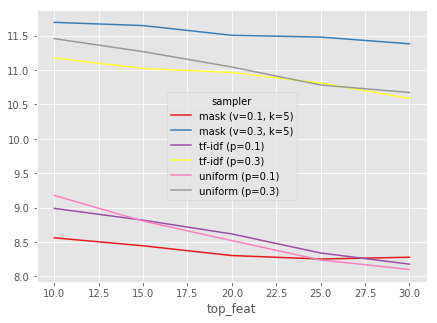

In [252]:
fig, ax = plt.subplots(figsize=(7,5))
error_frame.groupby(['top_feat', 'sampler'])['mse'].agg(np.mean).unstack().plot(colormap='Set1', ax=ax)

tf-idf (p=0.1)
tf-idf (p=0.3)
uniform (p=0.1)
uniform (p=0.3)
mask (v=0.1, k=5)
mask (v=0.3, k=5)


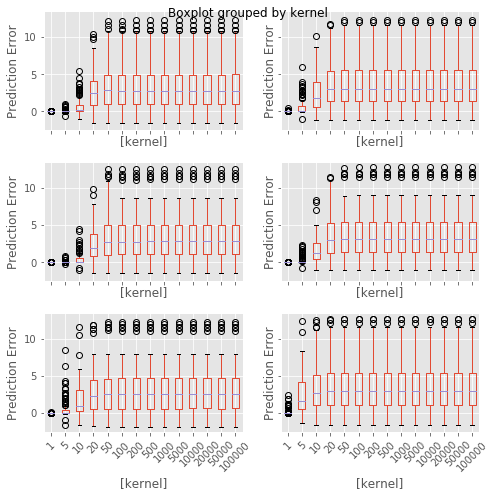

In [246]:
fig, axes = plt.subplots(3,2, figsize=(7,7), sharey=True, sharex =True)
for i,el in enumerate(list(explanation_frame['sampler'].unique())):
    print(el)
    a = explanation_frame[(explanation_frame['doc_rel'] == 1) & \
                          (explanation_frame['top_feat'] == 10) &\
                          (explanation_frame['sampler'] == el) ][['difference',\
                                                               'kernel']].boxplot(by=['kernel'],rot=45, \
                                                                                  ax=axes.flatten()[i])
    #a.set_xlabel('kernel size')
    a.set_title('')
    a.set_label('')
    a.set_ylabel('Prediction Error')
    
plt.title('')
plt.tight_layout() 
plt.show()



In [212]:
cand = explanation_frame[(explanation_frame['kernel'] == 50000) &\
                         (explanation_frame['top_feat'].isin([10,20])) &\
                         (explanation_frame['query_id'].isin([434,446,429])) & \
                         #(explanation_frame['doc_id'].isin(['FT924-8062','LA110389-0072','FBIS3-23777']))]
                         (explanation_frame['doc_id'].isin(['FT924-8062']))]

In [213]:
cand

,doc_id,doc_rel,doc_score,escore,intercept,kernel,local_pred,query_id,term_vector,top_feat,sampler
3162,FT924-8062,1,9.588725,0.091809,8.346275,50000,[8.70066107],446,"[('violenc', 1.170199096941159, 0.056961382316...",10,tf-idf (p=0.1)
3162,FT924-8062,1,9.588725,0.129276,8.386084,50000,[8.85887865],446,"[('violenc', 1.3259064803716318, 0.05696138231...",20,tf-idf (p=0.1)
3162,FT924-8062,1,9.588725,0.215066,7.751514,50000,[8.62667995],446,"[('violenc', 1.5303341823904804, 0.05696138231...",20,tf-idf (p=0.3)
3162,FT924-8062,1,9.588725,0.133537,7.745538,50000,[8.4072233],446,"[('violenc', 1.5191217725180561, 0.05696138231...",10,tf-idf (p=0.3)
3162,FT924-8062,1,9.588725,0.076070,8.361539,50000,[8.78080042],446,"[('violenc', 1.1656407280626755, 0.05696138231...",10,uniform (p=0.1)
3162,FT924-8062,1,9.588725,0.040008,8.419564,50000,[8.60324475],446,"[('violenc', 0.789771585438402, 0.056961382316...",20,uniform (p=0.1)
3162,FT924-8062,1,9.588725,0.184438,7.669132,50000,[8.48930851],446,"[('violenc', 1.2354384785002543, 0.05696138231...",20,uniform (p=0.3)
3162,FT924-8062,1,9.588725,0.272846,7.731993,50000,[8.55860032],446,"[('tourist', 1.5803292383480205, 0.51081137539...",10,uniform (p=0.3)
3162,FT924-8062,1,9.588725,0.149791,9.066536,50000,[8.99071901],446,"[('violenc', 1.8853609199714714, 0.05696138231...",20,"mask (v=0.1, k=5)"
3162,FT924-8062,1,9.588725,0.177200,8.864869,50000,[9.07507137],446,"[('violenc', 1.7263092509554958, 0.05696138231...",10,"mask (v=0.1, k=5)"


doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                 0.0918091
intercept                                                8.34628
kernel                                                     50000
local_pred                                          [8.70066107]
query_id                                                     446
term_vector    [('violenc', 1.170199096941159, 0.056961382316...
top_feat                                                      10
sampler                                           tf-idf (p=0.1)
Name: 3162, dtype: object


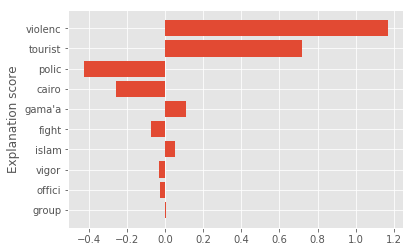

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                  0.129276
intercept                                                8.38608
kernel                                                     50000
local_pred                                          [8.85887865]
query_id                                                     446
term_vector    [('violenc', 1.3259064803716318, 0.05696138231...
top_feat                                                      20
sampler                                           tf-idf (p=0.1)
Name: 3162, dtype: object


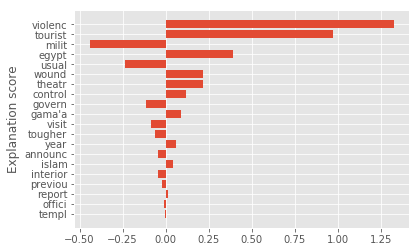

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                  0.215066
intercept                                                7.75151
kernel                                                     50000
local_pred                                          [8.62667995]
query_id                                                     446
term_vector    [('violenc', 1.5303341823904804, 0.05696138231...
top_feat                                                      20
sampler                                           tf-idf (p=0.3)
Name: 3162, dtype: object


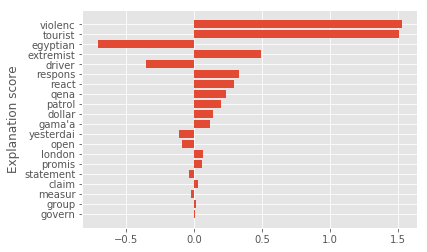

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                  0.133537
intercept                                                7.74554
kernel                                                     50000
local_pred                                           [8.4072233]
query_id                                                     446
term_vector    [('violenc', 1.5191217725180561, 0.05696138231...
top_feat                                                      10
sampler                                           tf-idf (p=0.3)
Name: 3162, dtype: object


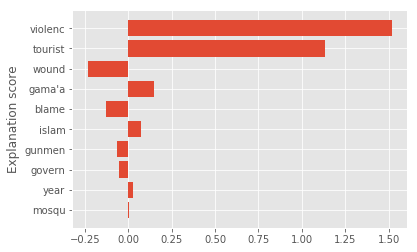

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                 0.0760705
intercept                                                8.36154
kernel                                                     50000
local_pred                                          [8.78080042]
query_id                                                     446
term_vector    [('violenc', 1.1656407280626755, 0.05696138231...
top_feat                                                      10
sampler                                          uniform (p=0.1)
Name: 3162, dtype: object


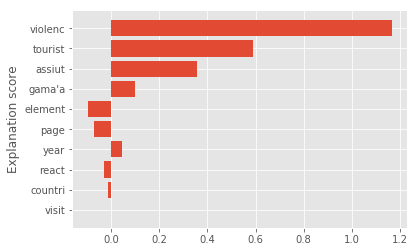

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                 0.0400085
intercept                                                8.41956
kernel                                                     50000
local_pred                                          [8.60324475]
query_id                                                     446
term_vector    [('violenc', 0.789771585438402, 0.056961382316...
top_feat                                                      20
sampler                                          uniform (p=0.1)
Name: 3162, dtype: object


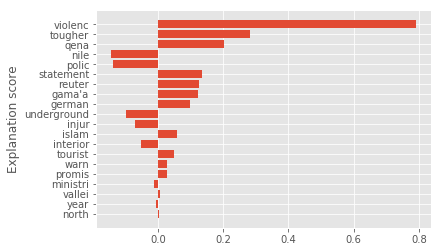

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                  0.184438
intercept                                                7.66913
kernel                                                     50000
local_pred                                          [8.48930851]
query_id                                                     446
term_vector    [('violenc', 1.2354384785002543, 0.05696138231...
top_feat                                                      20
sampler                                          uniform (p=0.3)
Name: 3162, dtype: object


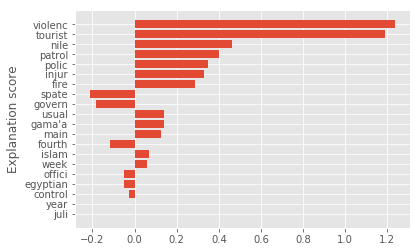

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                  0.272846
intercept                                                7.73199
kernel                                                     50000
local_pred                                          [8.55860032]
query_id                                                     446
term_vector    [('tourist', 1.5803292383480205, 0.51081137539...
top_feat                                                      10
sampler                                          uniform (p=0.3)
Name: 3162, dtype: object


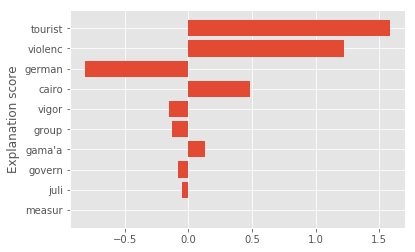

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                  0.149791
intercept                                                9.06654
kernel                                                     50000
local_pred                                          [8.99071901]
query_id                                                     446
term_vector    [('violenc', 1.8853609199714714, 0.05696138231...
top_feat                                                      20
sampler                                        mask (v=0.1, k=5)
Name: 3162, dtype: object


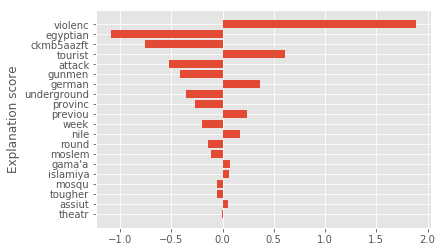

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                    0.1772
intercept                                                8.86487
kernel                                                     50000
local_pred                                          [9.07507137]
query_id                                                     446
term_vector    [('violenc', 1.7263092509554958, 0.05696138231...
top_feat                                                      10
sampler                                        mask (v=0.1, k=5)
Name: 3162, dtype: object


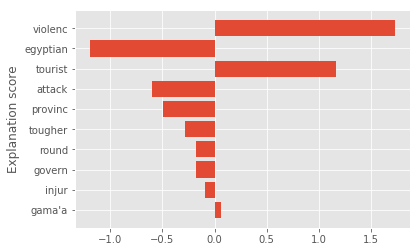

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                  0.116683
intercept                                                8.53136
kernel                                                     50000
local_pred                                          [8.67975555]
query_id                                                     446
term_vector    [('violenc', 1.1603851293447531, 0.05696138231...
top_feat                                                      10
sampler                                        mask (v=0.3, k=5)
Name: 3162, dtype: object


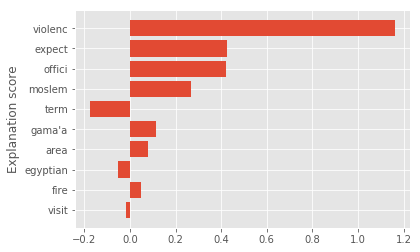

doc_id                                                FT924-8062
doc_rel                                                        1
doc_score                                                9.58873
escore                                                 0.0107409
intercept                                                8.67602
kernel                                                     50000
local_pred                                          [8.67294591]
query_id                                                     446
term_vector    [('assiut', 0.19407907245811043, 0.12652683970...
top_feat                                                      20
sampler                                        mask (v=0.3, k=5)
Name: 3162, dtype: object


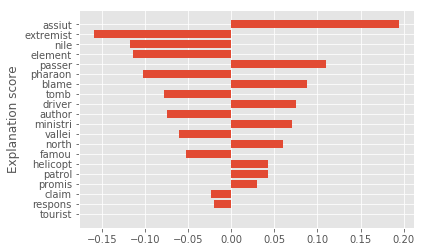

In [215]:
for index, row in cand.iterrows():
    print(row)
    word_tuples = literal_eval(row['term_vector'])
    stuples = sorted(word_tuples, key = lambda x: abs(x[1]))
    # reverse the tuples to go from most frequent to least frequent 
    words = [entry[0] for entry in stuples]
    score = [entry[1] for entry in stuples]
    x_pos = np.arange(len(words)) 

    plt.barh(x_pos, score, align='center')
    plt.yticks(x_pos, words) 
    plt.ylabel('Explanation score')
    plt.show()

[0.0, 5.0980105002993425e-14, 0.14159094976345843, 1.7874910893873068, 2.377932355445088, 2.5303097877755745, 2.572819584977555, 2.578884008178126, 2.5808241248008086, 2.5808847494797584, 2.5792685655532477, 2.580904149326045, 2.5809047555708458]
[4.685483288335163e-13, 0.00038346551857263653, 0.1632002674072132, 1.4534186484149245, 2.004116059818859, 2.1615293211907023, 2.2067820514779393, 2.213288933800443, 2.2153733358356433, 2.2154384905477, 2.214053762019393, 2.215459340274939, 2.2154599918306297]
[1.2171671890539076e-13, 0.030233572267840802, 0.11413695989843772, 0.16991944231170594, 0.18988989584032406, 0.19601876325030695, 0.19691517610432083, 0.19720314801435096, 0.19721215590817184, 0.19616257884671143, 0.19721503854654618, 0.19721512862987314]
[0.06615967605938462, 0.09210419161959917, 0.10180099124594318, 0.10479284294286585, 0.10523137586679174, 0.10537230365503705, 0.10537671232684787, 0.10491769802526761, 0.10537812316175092, 0.10537816725080988]
[7.723498896155977e-05, 

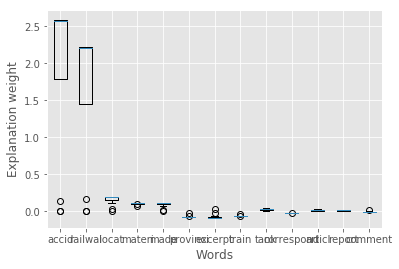

In [176]:
from ast import literal_eval
from scipy.stats import norm
import matplotlib.mlab as mlab

doc_groups = explanation_frame[explanation_frame['doc_rel'] == 1].groupby(['doc_id','query_id','top_feat','sampler'])

for gid, group in doc_groups:
    # find term score distribution across kernels
    word_scores = {}
    for index, row in group.iterrows():
        word_tuples = literal_eval(row['term_vector'])
        for entry in word_tuples:
            if entry[0] not in word_scores:
                word_scores[entry[0]] = []
            word_scores[entry[0]].append(entry[1])
    
    smeans = []
    for entry, value in word_scores.items():
        if len(value) > 2:
            smeans.append((entry, abs(np.mean(value))))
    
    values = []
    xticks = []
    for entry in sorted(smeans, key = lambda x: x[1], reverse=True):
        print(word_scores[entry[0]])
        values.append(word_scores[entry[0]])
        xticks.append(entry[0])
    
    plt.boxplot(values)
    plt.xticks(range(1,len(xticks)+1),xticks)
    '''
                (mu, sigma) = norm.fit(values)
                n, bins, patches = plt.hist(values, 10, normed=1, alpha=0.25)
                # add a 'best fit' line
                y = mlab.normpdf( bins, mu, sigma)
                l = plt.plot(bins, y,linewidth=2,label=word)
    '''

    #plot
    plt.xlabel('Words')
    #plt.ylim(0,40)
    plt.ylabel('Explanation weight')
    plt.grid(True)
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.11), ncol=3, fontsize= 11)
    plt.show()
    break

    
    

In [ ]:
tokenize_text('2790-0091 youths passengers staff diplomatic center 182123 77 77 182123 wire suffered')
indexPath = File(index_path).toPath()
index_dir = FSDirectory.open(indexPath)
reader = DirectoryReader.open(index_dir)
searcher = IndexSearcher(reader)

text_field = 'words'
analyzer = WhitespaceAnalyzer()
query_parser = QueryParser('id', analyzer)
score_docs = searcher.search(query_parser.parse(str('LA022790-0091')),1).scoreDocs

In [ ]:
import math
tc_dict = {}                     # Counts of each term
dc_dict = {}                     # Number of docs associated with each term
tfidf_dict = {}   
if len(score_docs) > 0:
    # get the tf-idf vector.
    termVector = reader.getTermVector(score_docs[0].doc, text_field);
    termsEnumvar = termVector.iterator()
    termsref = BytesRefIterator.cast_(termsEnumvar)
    N_terms = 0
    try:
        while (termsref.next()):
            termval = TermsEnum.cast_(termsref)
            fg = termval.term().utf8ToString()       # Term in unicode
            tc = termval.totalTermFreq()             # Term count in the doc

            # Number of docs having this term in the index
            dc = reader.docFreq(Term(text_field, termval.term())) 
            N_terms = N_terms + 1 
            tc_dict[fg]=tc
            dc_dict[fg]=dc
    except:
        print('error in term_dict')

    # Compute TF-IDF for each term
    for term in tc_dict:
        tf = tc_dict[term] / N_terms
        idf = 1 + math.log(reader.numDocs()/(dc_dict[term]+1)) 
        tfidf_dict[term] = tf*idf
